In [2]:
import os # 폴더 경로 생성하기 위해
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator # 입력 데이터 처리
from tensorflow.keras.applications import VGG16 # 성능은 좋지 않지만 알기 쉬운 pretrained network(기학습된 네트워크)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import warnings

warnings.filterwarnings('ignore')

train_dir = './data/cat_dog_small/train' # 학습용 이미지가 들어가 있는 폴더(상대경로)
validation_dir = './data/cat_dog_small/validation'

# ImageDataGenerator를 생성. 당연히 2개 생성
# train용 1개 - 증식 설정이 들어가야 해요!, validation용 1개 - 증식이 들어가면 안되요!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False, # 변형의 정도가 크기 때문에 사용 X
                                   fill_mode='nearest')

# validation data는 증식을 시키면 안되요!
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 설정
train_gen = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Model 구현
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
model_base.trainable = False # VGG16 안의 convolution layer를 동결(중요!)

model = Sequential()

 # 특징 추출하는 부분 (이미지 1장이 3차원)
model.add(model_base)

# classifier 구현 시작 (이미지 1장을 1차원으로)
model.add(Flatten()) 

# hidden layer
model.add(Dense(units=128))
model.add(BatchNormalization()) # 성능 향상을 위해 BatchNormalization을 사용해요!
model.add(Activation('relu'))
model.add(Dropout(rate=0.2)) # Activation 뒤에 위치시키는게 좋아요!(Dense 뒤에 위치)
                             # Convolution layer에서는 Dropout을 일반적으로 사용하지 않아요!

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [5]:
# Model 설정
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model 학습
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_gen,
                    validation_steps=50,
                    verbose=1)
# Epoch 30/30
# 100/100 [==============================] - 9s 91ms/step - loss: 0.1692 - 
# accuracy: 0.9325 - val_loss: 0.2476 - val_accuracy: 0.9060

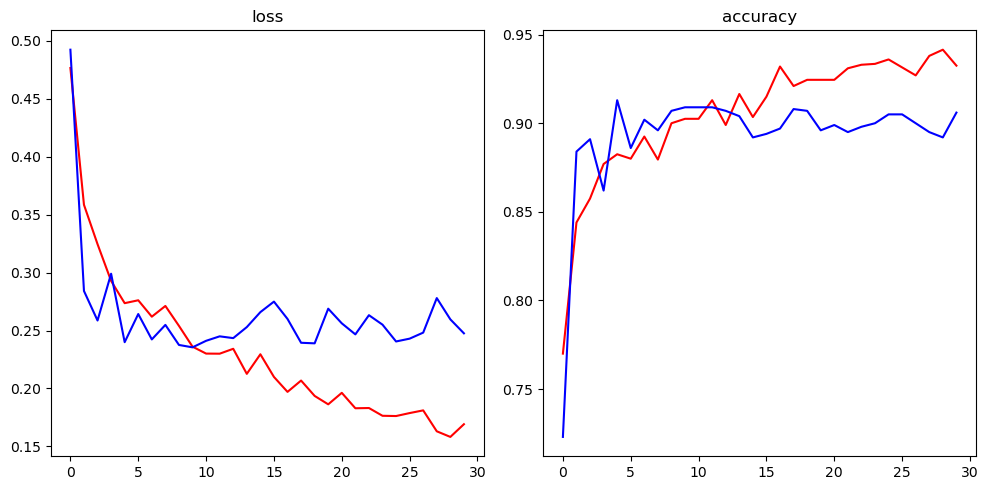

In [21]:
# 그래프
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()

plt.show()

In [ ]:
%reset
# 고양이와 멍멍이 이진분류 문제를
# VGG16을 이용한 Fine tuning으로 모델을 구현해 보아요!

# 데이터처리
import os # 폴더 경로 생성하기 위해
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator # 입력 데이터 처리
from tensorflow.keras.applications import VGG16 # 성능은 좋지 않지만 알기 쉬운 pretrained network(기학습된 네트워크)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

warnings.filterwarnings('ignore')

train_dir = './data/cat_dog_small/train' # 학습용 이미지가 들어가 있는 폴더(상대경로)
validation_dir = './data/cat_dog_small/validation'

# ImageDataGenerator를 생성. 당연히 2개 생성
# train용 1개 - 증식 설정이 들어가야 해요!, validation용 1개 - 증식이 들어가면 안되요!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False, # 변형의 정도가 크기 때문에 사용 X
                                   fill_mode='nearest')

# validation data는 증식을 시키면 안되요!
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 설정
train_gen = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# Model 구현
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
model_base.trainable = False # VGG16 안의 convolution layer를 동결(중요!)

model = Sequential()

 # 특징 추출하는 부분 (이미지 1장이 3차원)
model.add(model_base)

# classifier 구현 시작 (이미지 1장을 1차원으로)
model.add(Flatten()) 

# hidden layer
model.add(Dense(units=128))
model.add(BatchNormalization()) # 성능 향상을 위해 BatchNormalization을 사용해요!
model.add(Activation('relu'))
model.add(Dropout(rate=0.2)) # Activation 뒤에 위치시키는게 좋아요!(Dense 뒤에 위치)
                             # Convolution layer에서는 Dropout을 일반적으로 사용하지 않아요!

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

# Model 설정
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping & ModelCheckpoint callback 필요
es_callback = EarlyStopping(monitor='val_loss',
                            patience=5,
                            restore_best_weights=True,
                            verbose=1)
cp_callback = ModelCheckpoint(filepath='./finetune.weights.h5',
                              save_best_only=True,
                              save_weights_only=True,
                              monitor='val_accuracy',
                              verbose=1)

# Model 학습
model.fit(train_gen,
          steps_per_epoch=100,
          epochs=30,
          validation_data=validation_gen,
          validation_steps=50,
          callbacks=[es_callback, cp_callback],
          verbose=1)
# Epoch 16: val_accuracy did not improve from 0.90600
# 100/100 [==============================] - 9s 92ms/step - 
# loss: 0.2172 - accuracy: 0.9110 - val_loss: 0.2465 - val_accuracy: 0.9040
# Epoch 16: early stopping

In [ ]:
### 아래의 작업이 추가적으로 필요해요. Fine Tuning

# 현재 동결된 VGG16 안의 layer 중 일부를 동결에서 해제해야 해요!
# 학습이 안되는 상태인데 학습이 가능한 상태로 변경해야 해요!

# model_base.summary()
model_base.trainable = True

for layer in model_base.layers:
        if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
            layer.trainable = True
        else:
            layer.trainable = False

# Model 재설정 -> 다시 설정하지 않으면 적용되지 않아요!
# Fine Tuning할 때는 learning_rate를 더 작게 설정해요!
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model_base.summary()

# Model 학습(Fine Tuning)
model.fit(train_gen,
          steps_per_epoch=100,
          epochs=30,
          validation_data=validation_gen,
          validation_steps=50,
          callbacks=[es_callback, cp_callback],
          verbose=1)
# Epoch 13: val_accuracy did not improve from 0.93500
# 100/100 [==============================] - 9s 93ms/step - 
# loss: 0.0613 - accuracy: 0.9800 - val_loss: 0.1851 - val_accuracy: 0.9220
# Epoch 13: early stopping

In [32]:
# 우리 모델의 최종 accuracy를 구해보아요!
# Test data를 이용해서 최종 정확도를 구해보아요!
test_dir = './data/cat_dog_small/test'
test_datagen = ImageDataGenerator(rescale=1/255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

print(model.evaluate(test_gen))

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 38ms/step - loss: 0.1678 - accuracy: 0.9410
[0.16778357326984406, 0.9409999847412109]


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
100/100 [==============================] - 10s 94ms/step - loss: 0.7324 - accuracy: 0.6210 - val_loss: 95.6505 - val_accuracy: 0.5000


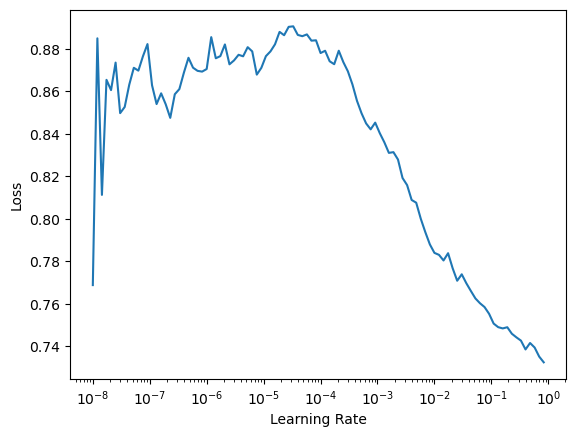

In [34]:
%reset
# leaning rate 최적화(callback을 이용하는 방법)
# 기존 고양이와 개 이진 학습하는 코드를 예로 들어서 알아보아요!
import os # 폴더 경로 생성하기 위해
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator # 입력 데이터 처리
from tensorflow.keras.applications import VGG16 # 성능은 좋지 않지만 알기 쉬운 pretrained network(기학습된 네트워크)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

warnings.filterwarnings('ignore')

train_dir = './data/cat_dog_small/train' # 학습용 이미지가 들어가 있는 폴더(상대경로)
validation_dir = './data/cat_dog_small/validation'

# ImageDataGenerator를 생성. 당연히 2개 생성
# train용 1개 - 증식 설정이 들어가야 해요!, validation용 1개 - 증식이 들어가면 안되요!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False, # 변형의 정도가 크기 때문에 사용 X
                                   fill_mode='nearest')

# validation data는 증식을 시키면 안되요!
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 설정
train_gen = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# Model 구현
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
model_base.trainable = False # VGG16 안의 convolution layer를 동결(중요!)

model = Sequential()

 # 특징 추출하는 부분 (이미지 1장이 3차원)
model.add(model_base)

# classifier 구현 시작 (이미지 1장을 1차원으로)
model.add(Flatten()) 

# hidden layer
model.add(Dense(units=128))
model.add(BatchNormalization()) # 성능 향상을 위해 BatchNormalization을 사용해요!
model.add(Activation('relu'))
model.add(Dropout(rate=0.2)) # Activation 뒤에 위치시키는게 좋아요!(Dense 뒤에 위치)
                             # Convolution layer에서는 Dropout을 일반적으로 사용하지 않아요!

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

# Model 설정
initial_lr = 1e-8
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# learning_rate 알아내는 사용자 정의 callback
class LRFinderCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-8, max_lr=10, steps=100):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps
        self.history = {
            'lr' : [],
            'loss' : []
        }

    def on_batch_end(self, batch, logs=None):
        lr = self.min_lr * (self.max_lr / self.min_lr) ** (batch / self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.history['lr'].append(lr)
        self.history['loss'].append(logs['loss'])

lr_finder = LRFinderCallback(min_lr=1e-8, max_lr=1, steps=100)

# Model 학습
model.fit(train_gen,
          steps_per_epoch=100,
          epochs=1,
          validation_data=validation_gen,
          validation_steps=50,
          callbacks=[lr_finder],
          verbose=1)

plt.plot(lr_finder.history['lr'], lr_finder.history['loss'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

plt.show()

In [ ]:
# 또 다른 방법은 optuna(라이브러리) 사용해서 알아내는 방법이 있어요!
# conda install -c conda-forge optuna
import optuna
import os # 폴더 경로 생성하기 위해
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator # 입력 데이터 처리
from tensorflow.keras.applications import VGG16 # 성능은 좋지 않지만 알기 쉬운 pretrained network(기학습된 네트워크)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

warnings.filterwarnings('ignore')

train_dir = './data/cat_dog_small/train' # 학습용 이미지가 들어가 있는 폴더(상대경로)
validation_dir = './data/cat_dog_small/validation'

# ImageDataGenerator를 생성. 당연히 2개 생성
# train용 1개 - 증식 설정이 들어가야 해요!, validation용 1개 - 증식이 들어가면 안되요!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False, # 변형의 정도가 크기 때문에 사용 X
                                   fill_mode='nearest')

# validation data는 증식을 시키면 안되요!
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 설정
train_gen = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# Model 구현
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
model_base.trainable = False # VGG16 안의 convolution layer를 동결(중요!)

model = Sequential()

 # 특징 추출하는 부분 (이미지 1장이 3차원)
model.add(model_base)

# classifier 구현 시작 (이미지 1장을 1차원으로)
model.add(Flatten()) 

# hidden layer
model.add(Dense(units=128))
model.add(BatchNormalization()) # 성능 향상을 위해 BatchNormalization을 사용해요!
model.add(Activation('relu'))
model.add(Dropout(rate=0.2)) # Activation 뒤에 위치시키는게 좋아요!(Dense 뒤에 위치)
                             # Convolution layer에서는 Dropout을 일반적으로 사용하지 않아요!

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

def objective(trial):
    lr = trial.suggest_loguniform('learning_rate', 1e-7, 1e-1)
    model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_gen,
                        steps_per_epoch=100,
                        epochs=10,
                        validation_data=validation_gen,
                        validation_steps=50,
                        callbacks=[lr_finder],
                        verbose=1)
    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_param = study.best_params['learning_rate']
print(f'최적의 parameter : {best_param}')
# 최적의 parameter : 0.8949999809265137